In [111]:
# -*- coding: utf-8 -*-
import gc
import logging
from abc import abstractmethod
from collections import defaultdict
from copy import deepcopy
from typing import Dict, List, Literal, Optional, Tuple, Union, cast

import lightning as L
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.utils.hooks
from accelerate import init_empty_weights
from torch import Tensor, nn
from tqdm.auto import tqdm
from transformers import AutoModelForCausalLM, LlamaForCausalLM
from typing_extensions import override

from fusion_bench.method import BaseModelFusionAlgorithm
from fusion_bench.method.pruning.prune_utils import (
    PruningType,
    compute_sparsity,
    find_linear_layers,
    semistructured_magnitude_prune_,
    unstructured_magnitude_prune_,
)
from fusion_bench.method.pruning.wanda_utils.data import get_loaders
from fusion_bench.method.pruning.wanda_utils.prune import prepare_calibration_input
from fusion_bench.mixins import SimpleProfilerMixin
from fusion_bench.modelpool import CausalLMPool
from fusion_bench.utils import cache_to_disk, print_parameters, timeit_context
from fusion_bench.utils.devices import get_device

# use times-new roman, no type 3 fonts
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
plt.rcParams["font.family"] = "Times New Roman"
# math font
plt.rcParams["mathtext.fontset"] = "cm"

In [182]:
def load_model(model_path):
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.float16,
    )
    return model


def iterative_weight_update(W, S, mask, rank):
    L = W - S
    u, sigma, vh = torch.linalg.svd(L.float(), full_matrices=False)
    v = vh.t()
    rank = min(sigma.size(0) - 1, rank)
    uk = u[:, rank:]
    sk = sigma[rank:]
    vk = v[:, rank:]
    S = S + (mask * (uk @ torch.diag(sk) @ vk.t())).to(S.dtype)
    spectrum_ratio = torch.sum(sigma[:rank] * sigma[:rank]) / torch.sum(sigma * sigma)
    return (S, spectrum_ratio)


def pcp_loss_with_mask(w, q, mask):
    _lambda = 1 / np.sqrt(np.max(w.size()))
    nuclear_loss = torch.linalg.matrix_norm((w * (~mask) + q * mask).float(), ord="nuc")
    l1_loss = _lambda * torch.linalg.matrix_norm((w * mask - q * mask).float(), ord=1)
    return nuclear_loss + l1_loss


def PCP_search_with_mask(w, mask, T_max=1000, lr=1e-2):
    q = torch.zeros_like(w).float().requires_grad_(True)
    optimizer = torch.optim.AdamW([q], lr=lr)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=T_max, eta_min=1e-1 * lr
    )
    for step_idx in tqdm(range(T_max)):
        optimizer.zero_grad()
        loss = pcp_loss_with_mask(w, q, mask)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        if step_idx % (T_max // 20) == 0:
            print(f"Step {step_idx}: Loss {loss.item()}")
    s = w * mask - q * mask
    return s


def random_matrix_with_rank_k(m, n, k):
    u = torch.randn(m, k)
    v = torch.randn(n, k)
    return u @ v.t()  # / np.sqrt(k)

In [163]:
def get_singluar_values(rank, sparsity_ratio, target_rank, m=512, n=512, T_max=100):
    W = random_matrix_with_rank_k(m, n, rank).to("cuda:4")
    S = unstructured_magnitude_prune_(
        W.clone(), torch.abs, sparsity_ratio=sparsity_ratio
    )
    mask = S != 0
    s_t = S.clone()
    for step_idx, r_t in tqdm(
        enumerate(np.linspace(2, target_rank, T_max, dtype=np.int64))
    ):
        s_t, spectrum_ratio = iterative_weight_update(W, s_t, mask, rank=r_t)
    return torch.linalg.svdvals(W - s_t.float())

In [184]:
data = defaultdict(list)

for _ in range(5):
    for w_rank in [512]:
        for sparsity_ratio in [0.3, 0.5, 0.7]:
            W = random_matrix_with_rank_k(512, 512, w_rank).to("cuda:4")
            S = unstructured_magnitude_prune_(
                W.clone(), torch.abs, sparsity_ratio=sparsity_ratio
            )
            L = W - S
            singular_values = torch.linalg.svdvals(L.float()).cpu().numpy()
            for i, sigma in enumerate(singular_values):
                data["label"].append(
                    R"$\boldsymbol{S}=\boldsymbol{W}\odot\boldsymbol{P}$"
                )
                data["w_rank"].append(w_rank)
                data["sparsity_ratio"].append(sparsity_ratio)
                data["index"].append(i)
                data["singular_value"].append(sigma)

    for w_rank in [512]:
        for sparsity_ratio in [0.3, 0.5, 0.7]:
            singular_values = (
                get_singluar_values(w_rank, sparsity_ratio, target_rank=512)
                .cpu()
                .numpy()
            )
            for i, sigma in enumerate(singular_values):
                data["label"].append(R"Ours")
                data["w_rank"].append(w_rank)
                data["sparsity_ratio"].append(sparsity_ratio)
                data["index"].append(i)
                data["singular_value"].append(sigma)

data = pd.DataFrame(data)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

/tmp/ipykernel_1310407/262247531.py:20: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  sns.lineplot(
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


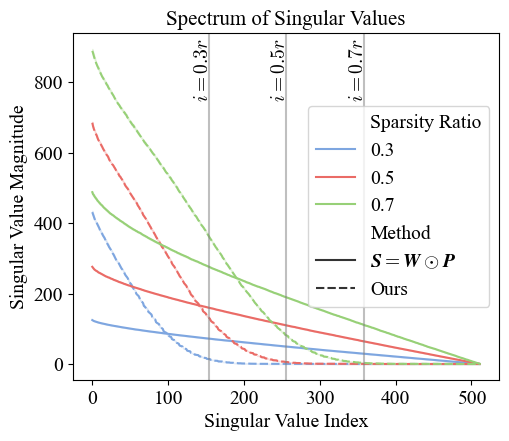

In [189]:
colors = [
    "#7EA6E0",
    "#EA6B66",
    "#97D077",
    "#FFB570",
    "#FF99FF",
    "#CCCC00",
    "#000099",
    "#666666",
    "#CCCCCC",
]

# set font size to 16
plt.rcParams.update({"font.size": 14})
# set the font size of title to 16
plt.rcParams.update({"axes.titlesize": 15})

plt.figure(figsize=(5.5, 4.5))

sns.lineplot(
    data=data[data["w_rank"] == 512],
    x="index",
    y="singular_value",
    hue="sparsity_ratio",
    style="label",
    palette=colors,
)

# plot vertical lines at 0.3 * 512, 0.5 * 512, 0.7 * 512
# as well text labels
plt.axvline(x=0.3 * 512, color="gray", alpha=0.5)
plt.axvline(x=0.5 * 512, color="gray", alpha=0.5)
plt.axvline(x=0.7 * 512, color="gray", alpha=0.5)
plt.text(0.3 * 512 - 20, 835, "$i=0.3r$", rotation=90, verticalalignment="center")
plt.text(0.5 * 512 - 20, 835, "$i=0.5r$", rotation=90, verticalalignment="center")
plt.text(0.7 * 512 - 20, 835, "$i=0.7r$", rotation=90, verticalalignment="center")

# change the pos of legend to center right
plt.legend(loc="center right", fontsize=8)

legend = plt.legend(loc="center right")
for text in legend.get_texts():
    if text.get_text() == "sparsity_ratio":
        text.set_text("Sparsity Ratio")
    elif text.get_text() == "label":
        text.set_text("Method")

plt.xlabel("Singular Value Index")
plt.ylabel("Singular Value Magnitude")
plt.title("Spectrum of Singular Values")

plt.savefig("spectrum.pdf", bbox_inches="tight")
plt.show()

In [166]:
data = defaultdict(list)

for _ in range(5):
    for w_rank in [64, 128, 256, 512]:
        for sparsity_ratio in [0.5]:
            W = random_matrix_with_rank_k(512, 512, w_rank).to("cuda:4")
            S = unstructured_magnitude_prune_(
                W.clone(), torch.abs, sparsity_ratio=sparsity_ratio
            )
            L = W - S
            singular_values = torch.linalg.svdvals(L.float()).cpu().numpy()
            for i, sigma in enumerate(singular_values):
                data["label"].append(
                    R"$\boldsymbol{S}=\boldsymbol{W}\odot\boldsymbol{P}$"
                )
                data["w_rank"].append(w_rank)
                data["sparsity_ratio"].append(sparsity_ratio)
                data["index"].append(i)
                data["singular_value"].append(sigma)

    for w_rank in [64, 128, 256, 512]:
        for sparsity_ratio in [0.5]:
            singular_values = (
                get_singluar_values(w_rank, sparsity_ratio, target_rank=512)
                .cpu()
                .numpy()
            )
            for i, sigma in enumerate(singular_values):
                data["label"].append(R"Ours")
                data["w_rank"].append(w_rank)
                data["sparsity_ratio"].append(sparsity_ratio)
                data["index"].append(i)
                data["singular_value"].append(sigma)

data = pd.DataFrame(data)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

/tmp/ipykernel_1310407/688813921.py:20: UserWarning: The palette list has more values (9) than needed (4), which may not be intended.
  sns.lineplot(
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


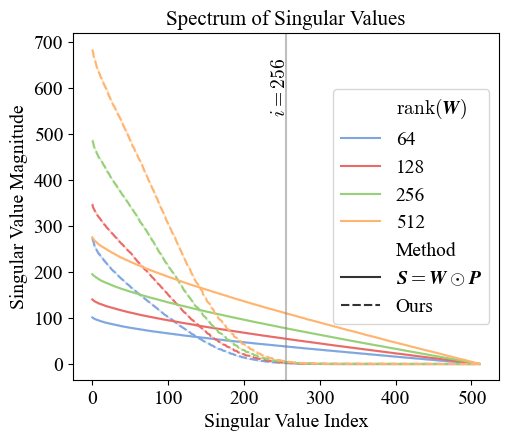

In [179]:
colors = [
    "#7EA6E0",
    "#EA6B66",
    "#97D077",
    "#FFB570",
    "#FF99FF",
    "#CCCC00",
    "#000099",
    "#666666",
    "#CCCCCC",
]

# set font size to 16
plt.rcParams.update({"font.size": 14})
# set the font size of title to 16
plt.rcParams.update({"axes.titlesize": 15})

plt.figure(figsize=(5.5, 4.5))

sns.lineplot(
    data=data,
    x="index",
    y="singular_value",
    hue="w_rank",
    style="label",
    palette=colors,
)

# plot vertical lines at 0.3 * 512, 0.5 * 512, 0.7 * 512
# as well text labels
# plt.axvline(x=0.3 * 512, color="gray", alpha=0.5)
plt.axvline(x=0.5 * 512, color="gray", alpha=0.5)
# plt.axvline(x=0.7 * 512, color="gray", alpha=0.5)
# plt.text(0.3 * 512 - 20, 32.5, "$x=0.3$", rotation=90, verticalalignment="center")
plt.text(0.5 * 512 - 20, 600, "$i=256$", rotation=90, verticalalignment="center")
# plt.text(0.7 * 512 - 20, 32.5, "$x=0.7$", rotation=90, verticalalignment="center")

# change the pos of legend to center right
plt.legend(loc="center right", fontsize=8)

legend = plt.legend(loc="center right")
for text in legend.get_texts():
    if text.get_text() == "w_rank":
        text.set_text(R"$\text{rank}(\boldsymbol{W})$")
    elif text.get_text() == "label":
        text.set_text("Method")

plt.xlabel("Singular Value Index")
plt.ylabel("Singular Value Magnitude")
# plt.yscale("log")
plt.title("Spectrum of Singular Values")

plt.savefig("spectrum_wrank.pdf", bbox_inches="tight")
plt.show()